<a href="https://colab.research.google.com/github/JohnYCLam/MachineLearning/blob/main/TensorFlow_and_PyTorch_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import cv2

import time
import PIL

In [ ]:
def load_img(path_to_img):
  max_dim = 224
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]

  plt.figure(figsize = (8, 8))
  plt.imshow(tensor)
  plt.axis('off')
  plt.show()

In [ ]:
content_image = load_img('louvre.jpg')
style_image = load_img('sandstone.jpg')

In [ ]:
content_layer = 'block5_conv2'

style_layers = {'block1_conv1': 1.0,
                'block2_conv1': 1.0,
                'block3_conv1': 1.0,
                'block4_conv1': 1.0,
                'block5_conv1': 1.0}

num_style_layers = len(style_layers)

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

outputs = [vgg.get_layer(key).output for key in style_layers.keys()]
outputs.append(vgg.get_layer(content_layer).output)

model = tf.keras.Model([vgg.input], outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,304,768 (58.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,304,768 (58.38 MB)

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
def extraction(input):
    input = input * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(input)
    preprocessed_input = tf.image.resize(preprocessed_input, (224, 224))

    outputs = model(preprocessed_input)

    content_output = outputs[-1]
    style_outputs = outputs[:-1]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    return content_output, style_outputs

In [ ]:
content_target = extraction(content_image)[0]
style_targets = extraction(style_image)[1]

In [ ]:
generated_target = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
content_weight = 1e4
style_weight = 1e-3

In [ ]:
def loss_fcn(outputs):
    content_output = outputs[0]
    style_outputs = outputs[1]

    content_loss = tf.reduce_mean((content_output - content_target)**2)
    content_loss *= content_weight

    style_loss = tf.add_n([style_layer_weight * tf.reduce_mean((style_output - style_target)**2) for style_layer_weight, style_output, style_target in zip(style_layers.values(), style_outputs, style_targets)])
    style_loss *= style_weight / num_style_layers

    loss = content_loss + style_loss

    return loss, content_loss, style_loss


In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extraction(image)
        loss, content_loss, style_loss = loss_fcn(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

    return loss, content_loss, style_loss

In [ ]:
total_start_time = time.time()
accumu_time = 0
for i in range(500):
    start_time = time.time()
    total_loss, content_loss, style_loss = train_step(generated_target)
    end_time = time.time()
    elapsed_time = end_time - start_time
    accumu_time += elapsed_time
    if (i+1) % 10 == 0:
        print(f'Iteration {i+1} || Total Loss: {total_loss} || Weighted Content Loss: {content_loss} || Weighted Style Loss: {style_loss} || Training Time: {accumu_time:.2f}')
        accumu_time = 0
total_end_time = time.time()
total_elapsed_time = total_end_time - total_start_time
print(f'Training Completed: Total Elapsed Time {total_elapsed_time}')

Iteration 10 || Total Loss: 19053010.0 || Weighted Content Loss: 4617731.5 || Weighted Style Loss: 14435278.0 || Training Time: 1.35
Iteration 20 || Total Loss: 15266888.0 || Weighted Content Loss: 4009418.25 || Weighted Style Loss: 11257470.0 || Training Time: 0.14
Iteration 30 || Total Loss: 13132685.0 || Weighted Content Loss: 3815603.25 || Weighted Style Loss: 9317082.0 || Training Time: 0.14
Iteration 40 || Total Loss: 11633241.0 || Weighted Content Loss: 3544749.25 || Weighted Style Loss: 8088491.5 || Training Time: 0.14
Iteration 50 || Total Loss: 10448213.0 || Weighted Content Loss: 3438419.5 || Weighted Style Loss: 7009793.5 || Training Time: 0.14
Iteration 60 || Total Loss: 9550650.0 || Weighted Content Loss: 3381130.75 || Weighted Style Loss: 6169519.5 || Training Time: 0.15
Iteration 70 || Total Loss: 8825554.0 || Weighted Content Loss: 3250015.75 || Weighted Style Loss: 5575538.0 || Training Time: 0.14
Iteration 80 || Total Loss: 8223364.0 || Weighted Content Loss: 3132881

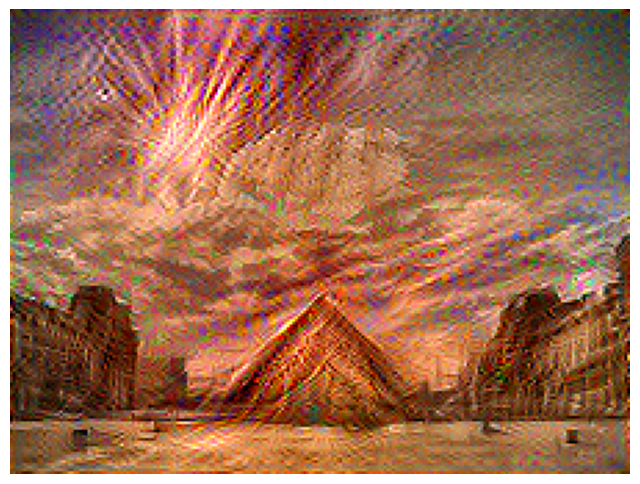

In [ ]:
tensor_to_image(generated_target)

## Stable Diffusion

In [ ]:
pip install diffusers transformers accelerate scipy safetensors

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler

# Load the model
model_id = "stabilityai/stable-diffusion-2-1-base"  # You can change this to your preferred model
pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to("cuda")  # Move the model to GPU if available


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Define the prompt
prompt = "An astronaut is riding on a donkey in the space over the Earth."

# Generate an image
with torch.no_grad():
    image = pipe(prompt, guidance_scale=7.5).images[0]

# Save the image
image.save("output_image.png")

# Display the image (optional)
image.show()

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
import PIL

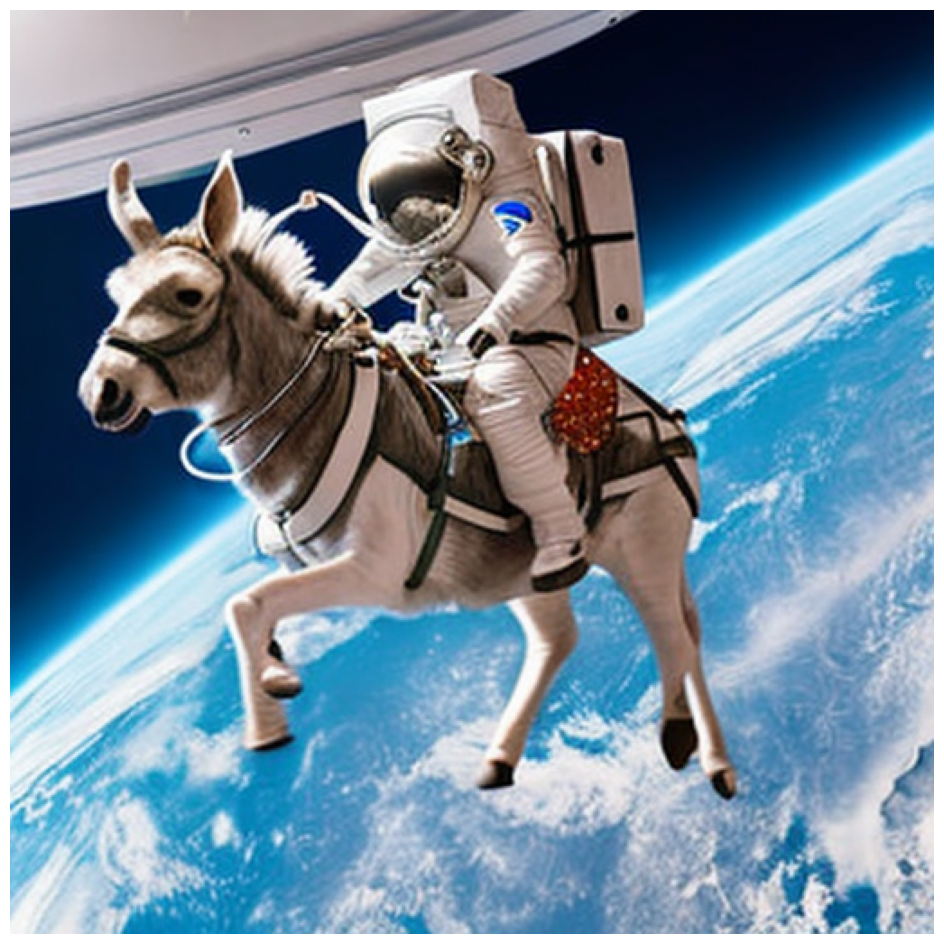

In [ ]:
img = PIL.Image.open('output_image.png')
plt.figure(figsize = (12,12))
plt.imshow(img)
plt.axis('off')
plt.show();